              precision    recall  f1-score   support

           0       0.97      0.85      0.90      1254
           1       0.20      0.62      0.30        79

    accuracy                           0.83      1333
   macro avg       0.59      0.73      0.60      1333
weighted avg       0.93      0.83      0.87      1333



['model.joblib']

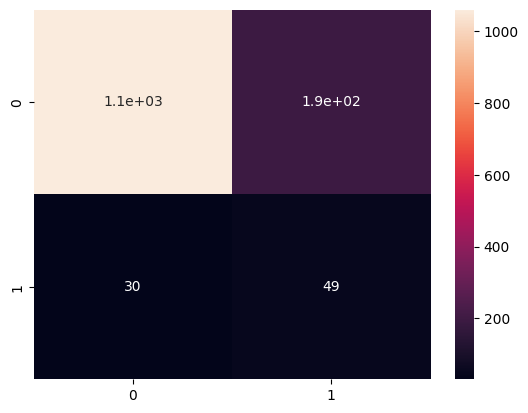

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import joblib

df = pd.read_csv('healthcare-dataset-stroke-data.csv')

df = df.drop(columns=['id'])

df = df[df['gender'] != 'Other']

df = df[df['work_type'] != 'Never_worked']

df_numeric = df[['age','avg_glucose_level','bmi','stroke']]

def remove_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)
    return df[mask]

# Separate DataFrames for each 'stroke' group
df_stroke_0 = df_numeric[df_numeric['stroke'] == 0]
df_stroke_1 = df_numeric[df_numeric['stroke'] == 1]

# Remove outliers within each group
df_stroke_0_no_outliers = remove_outliers_iqr(df_stroke_0)
df_stroke_1_no_outliers = remove_outliers_iqr(df_stroke_1)

# Combine the DataFrames back together
df_no_outliers = pd.concat([df_stroke_0_no_outliers, df_stroke_1_no_outliers])  

df_combined = df.merge(df_no_outliers, on=['age', 'avg_glucose_level', 'bmi', 'stroke'], how='inner')
df = df_combined

gender_map = {
    'Female': 0,
    'Male': 1
}

ever_married_map = {
    'No': 0,
    'Yes': 1
}

residence_type_map = {
    'Rural': 0,
    'Urban': 1
}

df['gender'] = df['gender'].map(gender_map)
df['ever_married'] = df['ever_married'].map(ever_married_map)
df['Residence_type'] = df['Residence_type'].map(residence_type_map)

df = pd.get_dummies(df, columns=['work_type','smoking_status'], dtype=int)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df[['age','avg_glucose_level','bmi']] = scaler.fit_transform(df[['age','avg_glucose_level','bmi']])

# joblib.dump(scaler, 'scaler.joblib')

from sklearn.linear_model import LinearRegression

train_data = df[df['bmi'].notnull()]  
test_data = df[df['bmi'].isnull()]

X_train = train_data.drop(columns=['bmi','stroke'])
y_train = train_data['bmi']
X_test = test_data.drop(columns=['bmi','stroke'])

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

df.loc[df['bmi'].isnull(), 'bmi'] = y_pred

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# classifier = LogisticRegression()

X = df.drop(columns=['stroke'])
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

classifier.fit(X_train_res, y_train_res)

y_pred = classifier.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
print(classification_report(y_test, y_pred))

joblib.dump(classifier, 'model.joblib')

In [3]:
df


,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,0.816895,0,1,1,1,0.801265,0.706989,1,0,1,0,0,0,1,0,0
1,0,0.743652,0,0,1,0,0.679023,0.524292,1,0,0,1,0,0,0,1,0
2,1,0.975586,0,1,1,0,0.234512,0.596774,1,0,1,0,0,0,0,1,0
3,0,0.597168,0,0,1,1,0.536008,0.647849,1,0,1,0,0,0,0,0,1
4,0,0.963379,1,0,1,0,0.549349,0.368280,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4438,0,0.157715,0,0,0,0,0.221402,0.223118,0,0,0,0,1,1,0,0,0
4439,0,0.975586,1,0,1,1,0.132167,0.566284,0,0,1,0,0,0,0,1,0
4440,0,0.987793,0,0,1,1,0.323516,0.798387,0,0,0,1,0,0,0,1,0
4441,0,0.426270,0,0,1,0,0.128658,0.545699,0,0,0,1,0,0,0,1,0


In [15]:
# columns: gender	age	hypertension	heart_disease	ever_married	Residence_type	avg_glucose_level	bmi	stroke	work_type_Govt_job	work_type_Private	work_type_Self-employed	work_type_children	smoking_status_Unknown	smoking_status_formerly smoked	smoking_status_never smoked	smoking_status_smokes

random_data = df.drop(columns=['stroke']).sample(1)

random_data

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
1253,0,0.450684,0,0,1,1,0.072154,0.685484,0,1,0,0,1,0,0,0


In [16]:
print(classifier.predict(random_data))

[0]
